In [1]:
from PIL import Image, ImageDraw 
import sys, os 
import cv2
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile

sys.path.append(os.getcwd()+"/ctpn")
from lib.fast_rcnn.config import cfg, cfg_from_file
from lib.fast_rcnn.test import _get_blobs
from lib.text_connector.detectors import TextDetector
from lib.text_connector.text_connect_cfg import Config as TextLineCfg
from lib.rpn_msr.proposal_layer_tf import proposal_layer


class LineDetector(object):
    def __init__ (self, pb_path='network/ctpn.pb'):
        # cfg_from_file('ctpn/text.yml')
        # init session
        self.config = tf.ConfigProto(allow_soft_placement=True)
        self.sess = tf.Session(config=self.config)
        with gfile.FastGFile( pb_path, 'rb') as f:
            self.graph_def = tf.GraphDef()
            self.graph_def.ParseFromString(f.read())
            self.sess.graph.as_default()
            tf.import_graph_def(self.graph_def, name='')
        self.sess.run(tf.global_variables_initializer())

        self.input_img = self.sess.graph.get_tensor_by_name('Placeholder:0')
        self.output_cls_prob = self.sess.graph.get_tensor_by_name('Reshape_2:0')
        self.output_box_pred = self.sess.graph.get_tensor_by_name('rpn_bbox_pred/Reshape_1:0')
    def resize_im(self, im, scale, max_scale=None):
        f = float(scale) / min(im.shape[0], im.shape[1])
        if max_scale != None and f * max(im.shape[0], im.shape[1]) > max_scale:
            f = float(max_scale) / max(im.shape[0], im.shape[1])
        return cv2.resize(im, None, None, fx=f, fy=f, interpolation=cv2.INTER_LINEAR), f

    def draw_boxes(self, img, boxes, scale):
        result = []
        for box in boxes:
            if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3] - box[0]) < 5:
                continue
            min_x = min(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
            min_y = min(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
            max_x = max(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
            max_y = max(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
            result.append((min_x, min_y, max_x, max_y)) 
            # fragment = [int (box[i]) for i in range(8)]
            # fragment[0], fragment[2] = fragment[2], fragment[0]
            # fragment[1], fragment[3] = fragment[3], fragment[1]
            # result.append(fragment) 
        return result 

    def run_image(self, img_arr):
        img = np.array(img_arr)
        img, scale = self.resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
        blobs, im_scales = _get_blobs(img, None)
        if cfg.TEST.HAS_RPN:
            im_blob = blobs['data']
            blobs['im_info'] = np.array(
                [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
                dtype=np.float32)
        cls_prob, box_pred = self.sess.run([self.output_cls_prob, self.output_box_pred], feed_dict={self.input_img: blobs['data']})
        rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

        scores = rois[:, 0]
        boxes = rois[:, 1:5] / im_scales[0]
        textdetector = TextDetector()
        boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
        result = self.draw_boxes(img, boxes, scale)
        return result

    def run_file(self, img_path):
        img_arr = cv2.imread(img_path)
        return self.run_image(img_arr)

/Users/cuonghn/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
line_detector = LineDetector()

### Utils

In [4]:
def read_bgr(fname):
    return cv2.imread(fname, 1)

def plot_img(img):
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)        

def read_rgb(fname):
    img = cv2.imread(fname, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def rgb2gray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    return gray

def resize(img):
    ratio = img.shape[0] / 100.0
    image = imutils.resize(img, height = 300)
    return image

def gray_to_bw(gray):
    thresh, im_bw = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return im_bw

def canny_edge(gray):
    edged = cv2.Canny(gray, 20, 100)
    return edged

def rgb_to_bgr(rgb):
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

def save_image(fname, img):
    cv2.imwrite(fname, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [5]:
red = (255, 0, 0)

#### Drawing

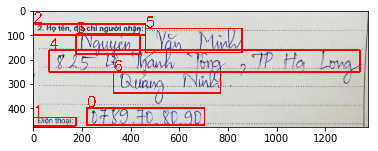

In [76]:
img = draw_boxes(fname, list_box)

In [73]:
save_image('output2.png', img)

### Join boxes

In [38]:
def draw_boxes(image, boxes):
    for i in range(len(boxes)):
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        
        cv2.rectangle(image, (x, y), (w, h), red, 5)
        cv2.putText(image, str(i), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    2, red, 4)
    
    plot_img(image)

    return image
       

def overlap(x0, x1):
    olap = [0] * 2
    
    if x0[0] >= x1[1] or x0[1] <= x1[0]:
        return 0.
    
    olap[0] = max(x0[0], x1[0])
    olap[1] = min(x0[1], x1[1])
    
#     print(x0, x1, olap)
    
    return len_x(*olap) * 1. / max(len_x(x0[0], x1[1]), len_x(x0[1], x1[0]))

def overlap_hor(x0, x1):
    olap = min(len_x(x0[1], x1[0]), len_x(x0[0], x1[1]))
    total =  max(len_x(x0[1], x1[0]), len_x(x0[0], x1[1]))
#     print(x0, x1, olap, total)
    return olap * 1. / total

def olap_box(box0, box1):
    x0 = [box0[1], box0[3]]
    x1 = [box1[1], box1[3]]
    return overlap(x0, x1)
    

def olap_box_hor(box0, box1):
    x0 = [box0[0], box0[2]]
    x1 = [box1[0], box1[2]]
    return overlap_hor(x0, x1)
    

def join_box(box0, box1):
    return (min(box0[0], box1[0]), min(box0[1], box1[1]), max(box0[2], box1[2]), max(box0[3], box1[3]))

def len_x(a, b):
    return abs(a - b)

def join_all_boxes(list_box):
    boxes = list_box.copy()
    
    # sort by x[1]
    boxes = sorted(boxes, key=lambda x: x[1])
    ret = []
    
    for i in range(len(boxes) - 1):
        if olap_box(boxes[i], boxes[i + 1]) > 0.6:
            if olap_box_hor(boxes[i], boxes[i + 1]) < 0.2:
                ret.append(i)
    
    ret_boxes = []
    # 
    i = 0
    while i < len(boxes):
        if i not in ret:
            ret_boxes.append(boxes[i])
            i += 1
        else:
            bb = join_box(boxes[i], boxes[i + 1])
            ret_boxes.append(bb)
            i += 2
    
    return ret_boxes
        

def join_all_boxes(list_box):
    boxes = list_box.copy()
    
    # sort by x[1]
    boxes = sorted(boxes, key=lambda x: x[1])
    ret_boxes = []
    ret_boxes.append(boxes[0])
    
    for i in range(len(boxes) - 1):
        if olap_box(ret_boxes[-1], boxes[i + 1]) > 0.6:
            box = ret_boxes.pop()
            box = join_box(box, boxes[i + 1])
            ret_boxes.append(box)
        else:
            ret_boxes.append(boxes[i + 1])
    
    return ret_boxes

boxes = join_all_boxes(list_box)

### Pipeline 

In [8]:
def get_out_name(fname):
    return fname.split('.')[0] + '_out.png'

def draw_boxes(image, boxes):
    for i in range(len(boxes)):
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        
        cv2.rectangle(image, (x, y), (w, h), red, 5)
        cv2.putText(image, str(i), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    2, red, 4)
    
    plot_img(image)

    return image  

### Too much noise

def boxes_pipeline(fname, line_detector=line_detector):
    print('Detecting boxes...')
    list_box = line_detector.run_file(fname)
    print('Got {} boxes'.format(len(list_box)))
    
    
    # Refine boxes
    img = read_rgb(fname)
    img_height = img.shape[0]

    boxes = refine_boxes(list_box, img_height, 0.11)

    # Draw
    img = draw_boxes(img, boxes)
    save_image(get_out_name(fname), img)
    return boxes

def refine_boxes(boxes, img_height, ratio=0.11):
    # Filter
    boxes = filter_boxes(boxes, img_height, ratio=ratio)
    print('Filter down to {} boxes.'.format(len(boxes)))
    
    # Join
    boxes = join_all_boxes(boxes)
    return boxes

def box_height(box):
    return abs(box[3] - box[1])

def filter_boxes(boxes, max_height, ratio=0.11):
    ret = []
    for box in boxes:
        rate = box_height(box) * 1. / max_height
        if rate > ratio:
            ret.append(box)
    return ret

In [118]:
list_box = line_detector.run_file(fname)

In [119]:
len(list_box)

13

array([[[222, 220, 208],
        [222, 220, 208],
        [223, 219, 208],
        ...,
        [199, 187, 171],
        [200, 188, 172],
        [200, 188, 172]],

       [[222, 220, 209],
        [223, 219, 209],
        [223, 219, 209],
        ...,
        [198, 187, 171],
        [199, 188, 172],
        [199, 188, 172]],

       [[223, 219, 210],
        [223, 219, 210],
        [223, 219, 210],
        ...,
        [198, 189, 172],
        [198, 189, 172],
        [198, 189, 172]],

       ...,

       [[218, 218, 216],
        [218, 219, 216],
        [218, 219, 214],
        ...,
        [183, 171, 148],
        [183, 171, 149],
        [183, 171, 149]],

       [[219, 220, 217],
        [219, 220, 216],
        [219, 220, 215],
        ...,
        [182, 170, 147],
        [181, 169, 147],
        [181, 169, 147]],

       [[219, 220, 215],
        [220, 221, 216],
        [219, 220, 215],
        ...,
        [181, 169, 146],
        [180, 168, 146],
        [180, 168, 146]]

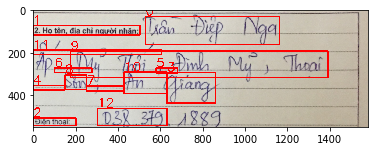

In [121]:
img = read_rgb(fname)

draw_boxes(img, list_box)

Filter down to 8 boxes.
[19, 117] [29, 108] [29, 108]
[177, 275] [189, 289] [189, 275]
[177, 289] [208, 277] [208, 277]
[177, 289] [280, 382] [280, 289]
[280, 382] [292, 373] [292, 373]
[280, 382] [362, 457] [362, 382]


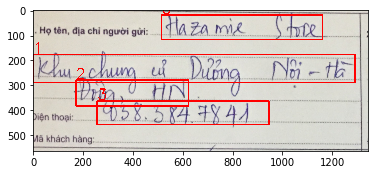

In [111]:
# Refine boxes
img = read_rgb(fname)
img_height = img.shape[0]

boxes = refine_boxes(list_box, img_height, 0.11)

# Draw
img = draw_boxes(img, boxes)
save_image(get_out_name(fname), img)

In [112]:
boxes

[(515, 19, 1160, 117),
 (0, 177, 1289, 289),
 (171, 280, 623, 382),
 (257, 362, 945, 457)]

In [44]:
fname = '000.png'

Detecting boxes...
Got 7 boxes
[258, 375] [264, 347] [264, 347]
[195, 1212] [58, 195] 0 1154
[358, 444] [385, 422] [385, 422]
Reduce to 6 boxes.


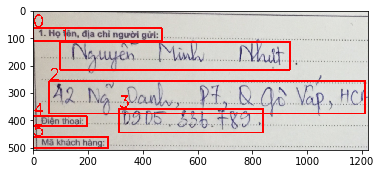

In [11]:
boxes = boxes_pipeline(fname, line_detector)

In [113]:
fname = 'region_from.png'

In [16]:
!ls

000.png           003.png           006_out.png       __pycache__
000_out.png       003_out.png       007.png           get_boxes.py
001.png           004.png           007_out.png       lib
001_out.png       004_out.png       010.jpg           network
001_out2.png      005.png           011.jpg
002.png           005_out.png       Merge boxes.ipynb
002_out.png       006.png           __init__.py


Detecting boxes...
Got 18 boxes
Filter down to 8 boxes.
[19, 117] [29, 108] [29, 108]
[177, 275] [189, 289] [189, 275]
[177, 289] [208, 277] [208, 277]
[177, 289] [280, 382] [280, 289]
[280, 382] [292, 373] [292, 373]
[280, 382] [362, 457] [362, 382]
Reduce to 4 boxes.


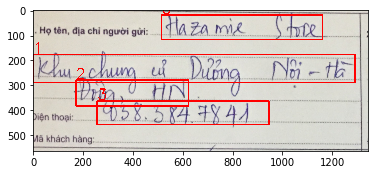

In [114]:
boxes = boxes_pipeline(fname, line_detector)

In [117]:
fname = 'region_to.png'

Detecting boxes...
Got 13 boxes
Filter down to 6 boxes.
Reduce to 5 boxes.


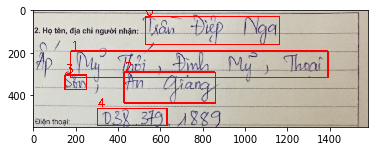

In [116]:
boxes = boxes_pipeline('region_to.png', line_detector)